In [4]:
import os
import random
import zipfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
import torchmetrics
from torch import nn, optim
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, io, transforms

In [2]:
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

In [3]:
set_seed(42)

In [6]:
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory already exist")
else:
    print(f"creating {image_path} directory")
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    print("downloading dataset...")
    response = requests.get(
        "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
    )
    f.write(response.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("unzipping dataset...")
    zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exist


In [7]:
image_list = list(image_path.glob("*/*/*.jpg"))

image_list[:5]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg')]

In [8]:
random_image = str(random.choice(image_list))

random_image

'data\\pizza_steak_sushi\\test\\sushi\\2394442.jpg'

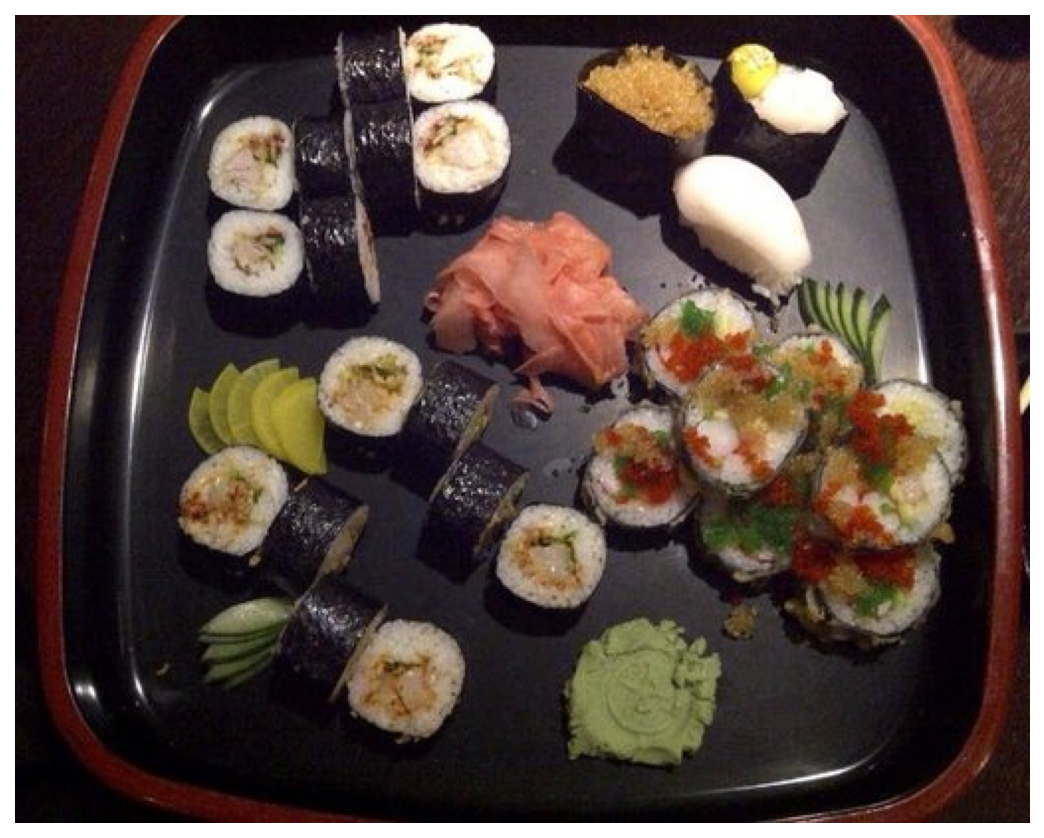

In [9]:
image = io.read_image(random_image)

plt.figure(figsize=(10, 7), dpi=150)
plt.imshow(image.permute(1, 2, 0))
plt.axis(False)

In [17]:
train_transform = transforms.Compose(
    [

        transforms.Resize((64, 64)),

        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),

    ]
)


test_transform = transforms.Compose(
    [transforms.Resize((64, 64)), transforms.ToTensor()]
)

In [18]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [19]:
train_gen = datasets.ImageFolder(train_dir, transform=train_transform)
test_gen = datasets.ImageFolder(test_dir, transform=test_transform)

In [20]:
train_gen, test_gen

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [21]:
classes = train_gen.classes

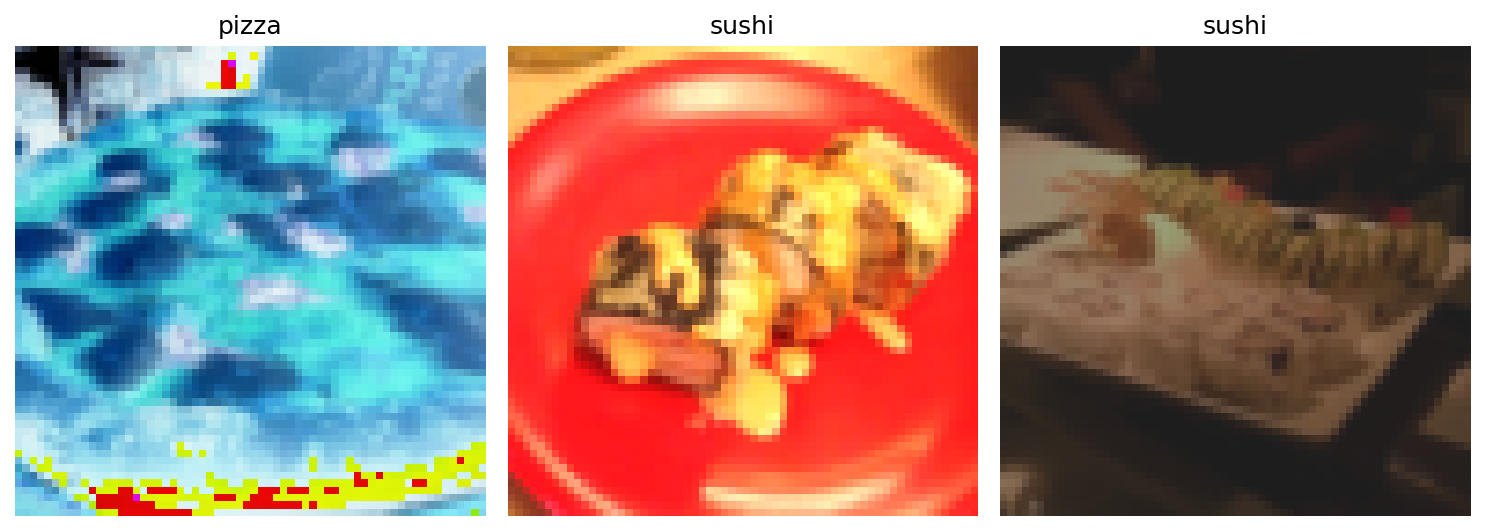

In [27]:
plt.figure(figsize=(10, 7), dpi=150)

for i, (X, y) in enumerate(random.choices(train_gen, k=3)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(X.permute(1, 2, 0))
    plt.title(classes[y])
    plt.axis(False)

plt.tight_layout()

In [52]:
batch_size = 32

train_loader = DataLoader(
    train_gen, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count()
)

test_loader = DataLoader(
    test_gen, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count()
)

In [53]:
class TinyVGG(nn.Module):
    def __init__(self, in_channels: int, out_features: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels, 10, 3, 1, "same"),
            nn.ReLU(),
            nn.Conv2d(10, 10, 3, 1, "same"),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(10, 10, 3, 1, "same"),
            nn.ReLU(),
            nn.Conv2d(10, 10, 3, 1, "same"),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 16 * 10, out_features),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.fc(x)

        return x


In [54]:
def train(
    dataloader: DataLoader,
    model: nn.Module,
    loss_fn: nn.Module,
    optimizer: optim.Optimizer,
    metric: torchmetrics.Metric,
):
    size = len(dataloader.dataset)

    for batch, (X, y) in enumerate(dataloader):
        model.train()

        y_logits = model(X)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

        loss = loss_fn(y_logits, y)
        acc = metric(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    final_acc = metric.compute()
    metric.reset()

    return final_acc.item()


In [55]:
def test(
    dataloader: DataLoader,
    model: nn.Module,
    loss_fn: nn.Module,
    metric: torchmetrics.Metric,
):
    num_batches = len(dataloader)

    test_loss = 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            model.eval()

            y_logits = model(X)
            y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

            test_loss += loss_fn(y_logits, y).item()
            acc = metric(y_pred, y)

    final_acc = metric.compute()
    metric.reset()

    test_loss /= num_batches

    print(
        f"Test Error: \n Accuracy: {(100*final_acc):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )

    return final_acc.item()


In [56]:
model = TinyVGG(3, len(classes))

model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [57]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
metric = torchmetrics.Accuracy(task="multiclass", num_classes=len(classes))


In [58]:
epochs = 5

for epoch in range(1, epochs + 1):
    print(f"Epoch {epoch}\n-------------------------------")
    train_acc = train(train_loader, model, loss_fn, optimizer, metric)
    test_acc = test(test_loader, model, loss_fn, metric)

Epoch 1
-------------------------------
loss: 1.102903  [   32/  225]
Test Error: 
 Accuracy: 33.3%, Avg loss: 1.097839 

Epoch 2
-------------------------------
loss: 1.102305  [   32/  225]
Test Error: 
 Accuracy: 41.3%, Avg loss: 1.085232 

Epoch 3
-------------------------------
loss: 1.095911  [   32/  225]
Test Error: 
 Accuracy: 40.0%, Avg loss: 1.095273 

Epoch 4
-------------------------------
loss: 1.091813  [   32/  225]
Test Error: 
 Accuracy: 34.7%, Avg loss: 1.089996 

Epoch 5
-------------------------------
loss: 1.102116  [   32/  225]
Test Error: 
 Accuracy: 32.0%, Avg loss: 1.104953 

